# Demo version 06.05.2022

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import lusi_Andreas_Loehr as lal

In [3]:
# Load functinos into global namespace
modify_metric = lal.modify_metric

## Load Data

In [4]:
# Load dataset, set batch size.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [5]:
# Prep train dataset.
eights = x_train[y_train == 8]/255
sevens = x_train[y_train == 7]/255

y_eights = np.ones(eights.shape[0])
y_sevens = np.zeros(sevens.shape[0])

# not needed as 
# eights_flat = np.reshape(eights, (-1, 784))
# sevens_flat = np.reshape(sevens, (-1, 784))
# x_train = np.concatenate([eights_flat, sevens_flat])

x_train_2d = np.concatenate([eights, sevens])
y_train = np.concatenate([y_eights, y_sevens])

In [6]:
# Dim checks.
print(f"Shape of 'eights' data: {eights.shape}")
print(f"Shape of 'sevens' data: {sevens.shape}")
print(f"Shape of entire training dataset: {x_train_2d.shape}")
print(f"Shape of training dataset labels: {y_train.shape}")

Shape of 'eights' data: (5851, 28, 28)
Shape of 'sevens' data: (6265, 28, 28)
Shape of entire training dataset: (12116, 28, 28)
Shape of training dataset labels: (12116,)


In [7]:
# Prep test dataset.
eights_test = x_test[y_test == 8]/255
sevens_test = x_test[y_test == 7]/255

y_eights_test = np.ones(eights_test.shape[0])
y_sevens_test = np.zeros(sevens_test.shape[0])

x_test = np.concatenate([eights_test, sevens_test])
y_test = np.concatenate([y_eights_test, y_sevens_test])

In [8]:
# Dim checks.
print(f"Shape of 'eights' test data: {eights_test.shape}")
print(f"Shape of 'sevens' test data: {sevens_test.shape}")
print(f"Shape of entire test dataset: {x_test.shape}")
print(f"Shape of entire test dataset labels: {y_test.shape}")

Shape of 'eights' test data: (974, 28, 28)
Shape of 'sevens' test data: (1028, 28, 28)
Shape of entire test dataset: (2002, 28, 28)
Shape of entire test dataset labels: (2002,)


In [9]:
# Load numpy array of predicate functions
preds = lal.phi
preds

array([<function avg_pixel_intensity at 0x1a0ba4790>,
       <function weighted_pixel_intesity at 0x1a0ba4940>,
       functools.partial(<function local_pixel_intensity_single at 0x1a0ba49d0>, patch=((10, 20), (10, 20)))],
      dtype=object)

In [10]:
# Evaluate predicates on training data
pred_eval = lal.apply_predicates_on_data(preds, x_train_2d)
pred_eval_test = lal.apply_predicates_on_data(preds, x_test)

2022-05-07 11:31:36.387081: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# Dim checks.
print(f"Type of pred_eval is: {type(pred_eval)}\n")
print(f"Shape of pred_eval is: {pred_eval.shape}. This is the result of applying {preds.shape[0]} predicates on the training data.\n")
print(f"Shape of pred_eval_test is: {pred_eval_test.shape}. This is the result of applying {preds.shape[0]} predicates on the test data.\n")
print(f"Shape of train dataset is: {x_train_2d.shape}")
print(f"Shape of training labels is: {y_train.shape}")

Type of pred_eval is: <class 'tensorflow.python.framework.ops.EagerTensor'>

Shape of pred_eval is: (12116, 3). This is the result of applying 3 predicates on the training data.

Shape of pred_eval_test is: (2002, 3). This is the result of applying 3 predicates on the test data.

Shape of train dataset is: (12116, 28, 28)
Shape of training labels is: (12116,)


In [15]:
# Batch training dataset and prepare for training with custom lusi loss.
# Important: Set reminder to true, else B in custom training loop might greater than batch_size of last batch.
train_dataset = tf.data.Dataset.from_tensor_slices((pred_eval, x_train_2d, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True)

### Zipped train datasets

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((pred_eval, x_train_2d, y_train))


train_dataset_b = train_dataset.shuffle(buffer_size=1024).batch(64, drop_remainder=True)
train_dataset_b_prime = train_dataset.shuffle(buffer_size=1024).batch(54, drop_remainder=True)

In [230]:
class LusiPeriphery:
    def __init__(self, train_data, test_data, model=None, predicates=None, batch_size_1=32, batch_size_2=32) -> None:
        """
        Train and test data in raw form
        """
        
    def generate_batch_data(self):
        pass
    
    def set_model(self):
        pass
    
    def set_batch_sizes(self):
        pass
    
    def set_predicates(self):
        pass
    
    def set_total_size(self):
        pass    
    

In [13]:
train_batch = tf.data.Dataset.zip((train_dataset_b, train_dataset_b_prime))

In [14]:
# Dim checks.
i = 0
for b, b_ in train_batch:
    if i < 2:
        print(f"Train batch 1 dimensions for batch number {i}: {b[0].shape, b[1].shape, b[2].shape}")
        print(f"Train batch 2 dimensions for batch number {i}: {b_[0].shape, b_[1].shape, b_[2].shape}")
        i+=1

Train batch 1 dimensions for batch number 0: (TensorShape([64, 3]), TensorShape([64, 28, 28]), TensorShape([64]))
Train batch 2 dimensions for batch number 0: (TensorShape([54, 3]), TensorShape([54, 28, 28]), TensorShape([54]))
Train batch 1 dimensions for batch number 1: (TensorShape([64, 3]), TensorShape([64, 28, 28]), TensorShape([64]))
Train batch 2 dimensions for batch number 1: (TensorShape([54, 3]), TensorShape([54, 28, 28]), TensorShape([54]))


In [15]:
a = tf.Variable(np.ones(shape=(2,3)))
b = tf.Variable(2 * np.ones(shape=(4,3)))
c = tf.concat([a,b], axis=0)
c

<tf.Tensor: shape=(6, 3), dtype=float64, numpy=
array([[1., 1., 1.],
       [1., 1., 1.],
       [2., 2., 2.],
       [2., 2., 2.],
       [2., 2., 2.],
       [2., 2., 2.]])>

In [16]:
for step, ((pred_batch_1, x_batch_train_1, y_batch_train_1), (pred_batch_2, x_batch_train_2, y_batch_train_2))  in enumerate(train_batch):
    if step <= 1:
        print(f"\nShapes for batches of step {step}:")
        print(f"Predicates batch 1 have shape {pred_batch_1.shape}")
        print(f"Predicates batch 2 have shape {pred_batch_2.shape}")
        print(f"x values batch 1 have shape {x_batch_train_1.shape}")
        print(f"x values batch 2 have shape {x_batch_train_2.shape}")
        print(f"y values batch 1 have shape {y_batch_train_1.shape}")
        print(f"y values batch 2 have shape {y_batch_train_2.shape}")


Shapes for batches of step 0:
Predicates batch 1 have shape (64, 3)
Predicates batch 2 have shape (54, 3)
x values batch 1 have shape (64, 28, 28)
x values batch 2 have shape (54, 28, 28)
y values batch 1 have shape (64,)
y values batch 2 have shape (54,)

Shapes for batches of step 1:
Predicates batch 1 have shape (64, 3)
Predicates batch 2 have shape (54, 3)
x values batch 1 have shape (64, 28, 28)
x values batch 2 have shape (54, 28, 28)
y values batch 1 have shape (64,)
y values batch 2 have shape (54,)


In [17]:
# Batch test dataset and prepare for evaluation with custom lusi loss.
# Important: Set reminder to true, else B in custom training loop might greater than batch_size of last batch.
test_dataset = tf.data.Dataset.from_tensor_slices((pred_eval_test, x_test, y_test))
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True)

In [18]:
# Dim checks.
i = 0
for b, b_ in zip(train_dataset, test_dataset):
    if i < 2:
        print(f"Train batch dimensions for batch number {i}: {b[0].shape, b[1].shape, b[2].shape}")
        print(f"Test batch dimensions for batch number {i}: {b_[0].shape, b_[1].shape, b_[2].shape}")
        i+=1
    

Train batch dimensions for batch number 0: (TensorShape([3]), TensorShape([28, 28]), TensorShape([]))
Test batch dimensions for batch number 0: (TensorShape([64, 3]), TensorShape([64, 28, 28]), TensorShape([64]))
Train batch dimensions for batch number 1: (TensorShape([3]), TensorShape([28, 28]), TensorShape([]))
Test batch dimensions for batch number 1: (TensorShape([64, 3]), TensorShape([64, 28, 28]), TensorShape([64]))


In [19]:
# train and testset for baseline model
train_dataset_baseline = tf.data.Dataset.from_tensor_slices((x_train_2d, y_train))
train_dataset_baseline = train_dataset_baseline.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True)

test_dataset_baseline = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset_baseline = test_dataset_baseline.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=False)

In [20]:
# Dim checks.
i = 0
for b, b_ in zip(train_dataset_baseline, test_dataset_baseline):
    if i < 2:
        print(f"Train batch dimensions for batch number {i}: {b[0].shape, b[1].shape}")
        print(f"Test batch dimensions for batch number {i}: {b_[0].shape, b_[1].shape}")
        i+=1
    

Train batch dimensions for batch number 0: (TensorShape([64, 28, 28]), TensorShape([64]))
Test batch dimensions for batch number 0: (TensorShape([64, 28, 28]), TensorShape([64]))
Train batch dimensions for batch number 1: (TensorShape([64, 28, 28]), TensorShape([64]))
Test batch dimensions for batch number 1: (TensorShape([64, 28, 28]), TensorShape([64]))


## Models

### Baseline model - standard neural net

In [21]:
# Baseline model
baseline_bin_class = keras.Sequential(
[
    layers.Flatten(input_shape=(28,28)),
    layers.Dense(100, activation="relu", name="hidden_layer_1"),
    # layers.Dense(500, activation="relu", name="hidden_layer_2"),
    layers.Dense(1, activation="sigmoid", name="output_layer") # interpret output as prob. for class 1
    # layers.Dense(1, name="output_layer", activation="relu")
])

In [22]:
baseline_bin_class.compile(
    optimizer=keras.optimizers.SGD(),
    # loss=keras.losses.SparseCategoricalCrossentropy(),
    # loss=keras.losses.binary_crossentropy(),
    loss = keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), "accuracy"],
)

In [23]:
# Model summary
baseline_bin_class.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden_layer_1 (Dense)      (None, 100)               78500     
                                                                 
 output_layer (Dense)        (None, 1)                 101       
                                                                 
Total params: 78,601
Trainable params: 78,601
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Evaluate baseline model on test set with no training.
baseline_bin_class.evaluate(x_test, y_test, batch_size=x_test.shape[0])

1/1 [==============================] - 0s 20ms/step - loss: 0.6101 - binary_accuracy: 0.6399 - accuracy: 0.6399


[0.6100670099258423, 0.6398601531982422, 0.6398601531982422]

In [26]:
# temp = np.mean(np.round(baseline_bin_class(x_test)[0]) == y_test)
temp = np.mean(tf.round(baseline_bin_class(x_test)[:, 0]) == y_test)

In [28]:
temp

0.6398601398601399

In [29]:
# Train baseline model for 10 epochs.
baseline_bin_class.fit(x_train_2d, y_train, batch_size=64, epochs=10)

Epoch 1/10
190/190 [==============================] - 0s 1ms/step - loss: 0.2543 - binary_accuracy: 0.9468 - accuracy: 0.9468
Epoch 2/10
190/190 [==============================] - 0s 1ms/step - loss: 0.1054 - binary_accuracy: 0.9746 - accuracy: 0.9746
Epoch 3/10
190/190 [==============================] - 0s 1ms/step - loss: 0.0773 - binary_accuracy: 0.9794 - accuracy: 0.9794
Epoch 4/10
190/190 [==============================] - 0s 1ms/step - loss: 0.0640 - binary_accuracy: 0.9822 - accuracy: 0.9822
Epoch 5/10
190/190 [==============================] - 0s 1ms/step - loss: 0.0560 - binary_accuracy: 0.9843 - accuracy: 0.9843
Epoch 6/10
190/190 [==============================] - 0s 1ms/step - loss: 0.0504 - binary_accuracy: 0.9853 - accuracy: 0.9853
Epoch 7/10
190/190 [==============================] - 0s 1ms/step - loss: 0.0463 - binary_accuracy: 0.9865 - accuracy: 0.9865
Epoch 8/10
190/190 [==============================] - 0s 1ms/step - loss: 0.0431 - binary_accuracy: 0.9870 - accuracy:

In [30]:
# Evaluate trained baseline model on test set.
baseline_bin_class.evaluate(x_test, y_test, batch_size=x_test.shape[0])

1/1 [==============================] - 0s 20ms/step - loss: 0.0530 - binary_accuracy: 0.9800 - accuracy: 0.9800


[0.053045302629470825, 0.9800199866294861, 0.9800199866294861]

#### Remarks:
One can recognize an improvement during training as well in the pre training evaluation score and the post training eval score.

### Custom model - standard neural net with custom LUSI training loss

In [326]:
weight_matrix = tf.cast(tf.linalg.diag(np.ones(len(preds))), dtype=tf.float32)

In [327]:
weight_matrix

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)>

In [328]:
# Note: The predicat evaluations are part of the dataset, thus predicates=None
lusi_net = lal.LusiModel(m_inner_prod=weight_matrix)
lusi_net.add_optimizer(tf.keras.optimizers.SGD())

In [329]:
lusi_net.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 784)               0         
                                                                 
 hidden_layer_01 (Dense)     (None, 100)               78500     
                                                                 
 output_layer (Dense)        (None, 1)                 101       
                                                                 
Total params: 78,601
Trainable params: 78,601
Non-trainable params: 0
_________________________________________________________________


In [330]:
# Specify some evaluation metrics for custom model
eval_metrics = [modify_metric(tf.keras.metrics.BinaryAccuracy(name="Binary Accuracy"), "pred_and_true"), 
                modify_metric(tf.keras.metrics.FalsePositives(name="False Positives"), "pred_and_true"), 
                modify_metric(tf.keras.metrics.FalseNegatives(name="False Negatives"), "pred_and_true"), 
                modify_metric(tf.keras.metrics.Precision(name="Precision"), "pred_and_true"), 
                modify_metric(tf.keras.metrics.Recall(name="Recall"), "pred_and_true"),
                # modify_metric(tf.keras.metrics.Mean(name="Mean"), "loss"),
                modify_metric(tf.keras.metrics.Accuracy(), "pred_and_true")
               ]

In [331]:
for eval_metric in eval_metrics:
    eval_metric.reset_state()
    print(eval_metric.result())

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


In [332]:
for e in eval_metrics:
    print(e.result())

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


In [333]:
lusi_net.evaluate((x_test, y_test), eval_metrics)

[('Binary Accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.45704296>),
 ('False Positives', <tf.Tensor: shape=(), dtype=float32, numpy=756.0>),
 ('False Negatives', <tf.Tensor: shape=(), dtype=float32, numpy=331.0>),
 ('Precision', <tf.Tensor: shape=(), dtype=float32, numpy=0.459614>),
 ('Recall', <tf.Tensor: shape=(), dtype=float32, numpy=0.6601643>),
 ('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.45704296>)]

In [334]:
lusi_net.evaluate_testset(x_test, y_test, eval_metrics)

[('Binary Accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.45704296>),
 ('False Positives', <tf.Tensor: shape=(), dtype=float32, numpy=756.0>),
 ('False Negatives', <tf.Tensor: shape=(), dtype=float32, numpy=331.0>),
 ('Precision', <tf.Tensor: shape=(), dtype=float32, numpy=0.459614>),
 ('Recall', <tf.Tensor: shape=(), dtype=float32, numpy=0.6601643>),
 ('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.45704296>)]

In [335]:
test_eval_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_eval_dataset = test_eval_dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True)
lusi_net.evaluate(test_eval_dataset, eval_metrics)

[('Binary Accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.45816532>),
 ('False Positives', <tf.Tensor: shape=(), dtype=float32, numpy=745.0>),
 ('False Negatives', <tf.Tensor: shape=(), dtype=float32, numpy=330.0>),
 ('Precision', <tf.Tensor: shape=(), dtype=float32, numpy=0.46209386>),
 ('Recall', <tf.Tensor: shape=(), dtype=float32, numpy=0.6597938>),
 ('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.45816532>)]

In [286]:
 1- (971 + 4)/2002

0.512987012987013

In [264]:
# Pre training evaluation on test dataset (Calculate scores for each batch and average over batches)
# Caution: Evaluation for 'Mean' metric not yet implemented.
lusi_net.evaluate(test_dataset, eval_metrics)

[('Binary Accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.43699807>),
 ('False Positives', <tf.Tensor: shape=(), dtype=float32, numpy=1541.0>),
 ('False Negatives', <tf.Tensor: shape=(), dtype=float32, numpy=703.0>),
 ('Precision', <tf.Tensor: shape=(), dtype=float32, numpy=0.44588277>),
 ('Recall', <tf.Tensor: shape=(), dtype=float32, numpy=0.63818836>),
 ('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.4370296>)]

In [265]:
y_pred_test_temp = lusi_net.predict(x_test)
y_pred_test_temp = np.asarray([j[0] for j in y_pred_test_temp])
y_pred_test_temp
np.mean(np.round(y_pred_test_temp) ==  y_test )

0.4370629370629371

In [287]:
lusi_net.train_correct(train_batch, 2, train_metrics=eval_metrics)


Start of epoch 0
Training loss (for one batch) at step 0: -0.9568
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.8413
Seen so far: 6464 samples

Start of epoch 1
Training loss (for one batch) at step 0: -0.9786
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.2289
Seen so far: 6464 samples


In [290]:
lusi_net.evaluate_testset(x_test, y_test, eval_metrics)

[('Binary Accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.8896104>),
 ('False Positives', <tf.Tensor: shape=(), dtype=float32, numpy=14.0>),
 ('False Negatives', <tf.Tensor: shape=(), dtype=float32, numpy=207.0>),
 ('Precision', <tf.Tensor: shape=(), dtype=float32, numpy=0.98207426>),
 ('Recall', <tf.Tensor: shape=(), dtype=float32, numpy=0.78747433>),
 ('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.8896104>)]

In [273]:
y_pred_test_temp = lusi_net.predict(x_test)
y_pred_test_temp = np.asarray([j[0] for j in y_pred_test_temp])
y_pred_test_temp
np.mean(np.round(y_pred_test_temp) ==  y_test )

0.8396603396603397

In [291]:
1 - 221/2002

0.8896103896103896

In [220]:
lusi_net.evaluate(test_dataset, eval_metrics)

[('Binary Accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.8684476>),
 ('False Positives', <tf.Tensor: shape=(), dtype=float32, numpy=24.0>),
 ('False Negatives', <tf.Tensor: shape=(), dtype=float32, numpy=237.0>),
 ('Precision', <tf.Tensor: shape=(), dtype=float32, numpy=0.96816975>),
 ('Recall', <tf.Tensor: shape=(), dtype=float32, numpy=0.7549121>),
 ('Mean', <tf.Tensor: shape=(), dtype=float32, numpy=0.0>),
 ('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.8684476>)]

In [221]:
1 - (237+24)/2002

0.8696303696303697

In [56]:
# Train custom model for 10 epochs
# lusi_net.train(train_dataset, 10, train_metrics=eval_metrics,  batch_1_size=32)

In [295]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [299]:
train_dataset.dtype

AttributeError: 'TensorSliceDataset' object has no attribute 'dtype'

In [307]:
isinstance(train_dataset, tf.data.Dataset)
isinstance(x_test, np.ndarray)

True

In [199]:
# Inspection of training progress
# Epoch -1 is evaluation before first gradient update in epoch 0
for j,e in enumerate(lusi_net.epoch_train_metrics_results):
    print(f"----- Epoch {j-1} -----")
    for i in e:
        print(f"{i[0]}: {i[1]}")

----- Epoch -1 -----
Binary Accuracy: 0.3720952570438385
False Positives: 1377.0
False Negatives: 1184.0
Precision: 0.3885435163974762
Recall: 0.4249635636806488
Mean: -0.0177740640938282
accuracy: 0.3732256591320038
----- Epoch 0 -----
Binary Accuracy: 0.7284815907478333
False Positives: 4657.0
False Negatives: 1278.0
Precision: 0.7263163924217224
Recall: 0.9062843918800354
Mean: -0.014887074008584023
accuracy: 0.7740768790245056
----- Epoch 1 -----
Binary Accuracy: 0.9159720540046692
False Positives: 1471.0
False Negatives: 403.0
Precision: 0.8847630023956299
Recall: 0.965546727180481
Mean: -0.13331307470798492
accuracy: 0.9159716367721558


In [200]:
lusi_net.evaluate(test_dataset, eval_metrics)

[('Binary Accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.8359375>),
 ('False Positives', <tf.Tensor: shape=(), dtype=float32, numpy=22.0>),
 ('False Negatives', <tf.Tensor: shape=(), dtype=float32, numpy=629.0>),
 ('Precision', <tf.Tensor: shape=(), dtype=float32, numpy=0.98340875>),
 ('Recall', <tf.Tensor: shape=(), dtype=float32, numpy=0.67459905>),
 ('Mean', <tf.Tensor: shape=(), dtype=float32, numpy=0.0>),
 ('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.8359375>)]

In [201]:
lusi_net_test_pred = np.round(lusi_net.predict(x_test))
preds_y_test = np.asarray([j[0] for j in lusi_net_test_pred])

In [247]:
1- (22 + 629)/2002

0.6748251748251748

In [202]:
preds_y_test.shape

(2002,)

In [203]:
np.mean(preds_y_test == y_test)

0.8361638361638362

#### Visual validation

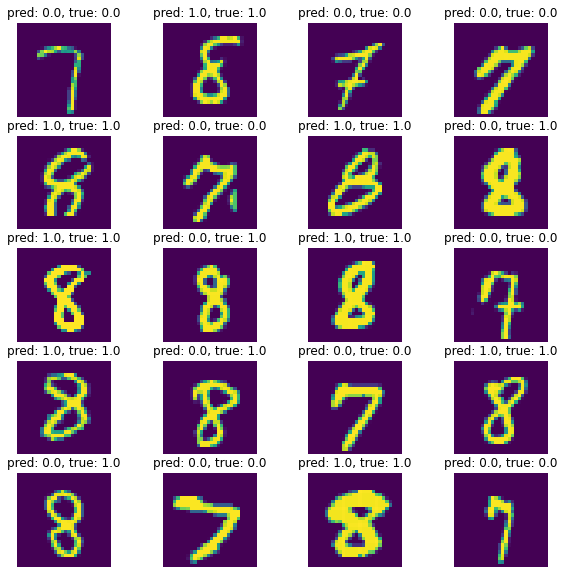

In [206]:
random_indices = np.random.randint(0, high=x_test.shape[0], size=20).reshape(5,4)
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(10,10))
fig.figsize=(10,10)

for i in range(5):
    for j in range(4):
        ax[i,j].imshow(x_test[random_indices[i,j]])
        ax[i,j].set_title(f"pred: {lusi_net_test_pred[random_indices[i,j]][0]}, true: {y_test[random_indices[i,j]]}")
        ax[i,j].axis("off")

In [207]:
lusi_net.watches_vars

(<tf.Variable 'hidden_layer_01/kernel:0' shape=(784, 100) dtype=float32, numpy=
 array([[ 0.01029615,  0.07308923,  0.0528736 , ...,  0.01764344,
          0.03428844,  0.06806841],
        [ 0.04321082, -0.03620856, -0.07285321, ...,  0.00256582,
          0.01069878,  0.01379132],
        [-0.01839224, -0.00344887, -0.04425785, ..., -0.03740519,
          0.0312849 , -0.04990429],
        ...,
        [-0.06186682,  0.0360487 ,  0.07773726, ..., -0.03847785,
         -0.07957546, -0.02448065],
        [ 0.05378409, -0.07762517,  0.04541375, ...,  0.03921954,
          0.07320769,  0.00610677],
        [ 0.05557923, -0.00094198, -0.05384734, ..., -0.02304952,
          0.0453769 , -0.02132869]], dtype=float32)>,
 <tf.Variable 'hidden_layer_01/bias:0' shape=(100,) dtype=float32, numpy=
 array([ 2.26809527e-04,  3.96134565e-03, -4.38527612e-04, -5.05398260e-04,
         4.54691658e-03, -2.63975060e-04, -2.56159110e-04, -3.66585399e-03,
        -8.84142704e-03,  2.18607159e-03, -4.288167

In [240]:
temp = (lusi_net.model_weight_list[4][1][0] - lusi_net.model_weight_list[15][1][0])

In [245]:
print(np.max(temp[temp != 0]))
print(np.min(temp[temp != 0]))


0.0033567557
-0.004465893


In [230]:
lusi_net.layers[0].get_weights()

[array([[ 4.8890710e-05,  3.0188531e-02, -4.0214725e-02, ...,
         -1.3065308e-02, -2.8753571e-02, -4.9196303e-02],
        [-7.3631488e-02,  4.3032289e-02, -6.9208182e-02, ...,
         -7.8303888e-02,  2.5965855e-02,  5.5982769e-02],
        [ 4.7780767e-02, -6.9650389e-02, -3.1469338e-02, ...,
          1.7053321e-02, -2.0180274e-02,  6.0287729e-02],
        ...,
        [ 4.6156347e-02, -1.6654171e-02, -1.3102941e-02, ...,
          3.8317069e-02,  4.9839109e-02, -4.5718636e-02],
        [-5.2456081e-02,  7.4608058e-02, -2.8712895e-02, ...,
         -2.5966190e-02, -2.2572141e-02, -4.1668400e-02],
        [ 7.1549192e-02,  1.4410384e-02, -4.1738898e-02, ...,
         -5.7290137e-02,  4.4993132e-02,  1.8160544e-02]], dtype=float32),
 array([ 5.7783659e-04, -1.3924793e-03, -5.2779360e-04, -4.4235124e-04,
        -1.4338095e-03, -5.7914876e-05,  1.1531371e-02, -2.4699224e-03,
         2.2904804e-02,  5.6161243e-05,  3.2234148e-04, -4.1506483e-04,
         4.5874060e-04,  1.7970765

In [178]:
lusi_net.model_weight_list[4]

((0, 3),
 ListWrapper([array([[-0.03290785, -0.0049599 , -0.06872204, ..., -0.02190971,
          0.04855919,  0.048613  ],
        [-0.04266789, -0.03542301,  0.02982783, ..., -0.06789184,
          0.01476679,  0.01816675],
        [-0.0708926 ,  0.00394389,  0.0236842 , ...,  0.05096431,
         -0.05892266,  0.06849761],
        ...,
        [ 0.0201686 ,  0.04717921,  0.0217082 , ..., -0.0435766 ,
         -0.02208497, -0.08158264],
        [-0.00258563,  0.05347441,  0.02945437, ..., -0.05903338,
          0.02728259,  0.06087816],
        [-0.05981946, -0.0771868 , -0.03381646, ...,  0.03348702,
         -0.07569855, -0.07999133]], dtype=float32), array([ 4.5682047e-04,  3.8227742e-03,  5.5619900e-04, -5.8357842e-04,
        -1.4825790e-04, -1.0391799e-03, -5.1099993e-04, -1.0579149e-03,
         1.1329939e-04,  2.3807606e-03, -1.0065484e-03, -2.8342973e-03,
         2.6445771e-03, -1.3772832e-03, -3.7042033e-03,  2.5061311e-04,
         3.0714814e-03,  1.5233811e-03,  2.200921

### Temporary Issues - old implementation -> ignore

**Issue no 1.**

Während des Trainings kann man einsehen, dass alle Modellparameter des neuronales Netztes vom gradient tape beobachtet werden. Problematisch ist alelrdings, dass man für die erste Matrix von der Dim (784, 100) des ersten Layers immer 0 als Gradienten erhält. Die restlichen Gradienten sind nicht 0.

**Geklärt!!!** Ist beim neuen Modell nicht mehr so...

Trotzdem gut zur Illustration

In [174]:
lusi_net = lal.LusiModel(predicates=None, weight_matrix=weight_matrix)
lusi_net.add_optimizer(tf.keras.optimizers.SGD())
lusi_net.evaluate(test_dataset, eval_metrics)

[('Binary Accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.8142556>),
 ('False Positives', <tf.Tensor: shape=(), dtype=float32, numpy=848.0>),
 ('False Negatives', <tf.Tensor: shape=(), dtype=float32, numpy=274.0>),
 ('Precision', <tf.Tensor: shape=(), dtype=float32, numpy=0.83850694>),
 ('Recall', <tf.Tensor: shape=(), dtype=float32, numpy=0.9414154>),
 ('Mean', <tf.Tensor: shape=(), dtype=float32, numpy=-0.24690153>),
 ('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.80301964>)]

In [175]:
# Train custom model for 10 epochs
lusi_net.train_debug(train_dataset, 5, train_metrics=eval_metrics,  batch_1_size=32)


Start of epoch 0
Training loss (for one batch) at step 0: -1.1264
Seen so far: 64 samples
Training loss (for one batch) at step 100: 1.2990
Seen so far: 6464 samples

Start of epoch 1
Training loss (for one batch) at step 0: -0.6952
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.3608
Seen so far: 6464 samples

Start of epoch 2
Training loss (for one batch) at step 0: -1.1882
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.1167
Seen so far: 6464 samples

Start of epoch 3
Training loss (for one batch) at step 0: -0.8993
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.2571
Seen so far: 6464 samples

Start of epoch 4
Training loss (for one batch) at step 0: -0.6263
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.1625
Seen so far: 6464 samples


In [186]:
lusi_net.model_weight_list[0]

(-1,
 ListWrapper([<tf.Variable 'hidden_layer_01/kernel:0' shape=(784, 100) dtype=float32, numpy=
 array([[-0.0370429 ,  0.01856136,  0.01109488, ..., -0.00165075,
         -0.04981851, -0.03788538],
        [-0.08224574, -0.0169937 , -0.06788497, ..., -0.04744552,
         -0.07561758, -0.00373816],
        [-0.03309216, -0.0767751 ,  0.02286159, ...,  0.04550548,
          0.01688451, -0.04940302],
        ...,
        [-0.01363045,  0.0018331 ,  0.00059545, ..., -0.05137364,
          0.01653846,  0.01442146],
        [-0.06955153,  0.06206992, -0.02738059, ...,  0.05478401,
          0.02380726,  0.07367747],
        [-0.0182959 , -0.0309881 , -0.06341801, ..., -0.08149514,
          0.062833  , -0.03134453]], dtype=float32)>, <tf.Variable 'hidden_layer_01/bias:0' shape=(100,) dtype=float32, numpy=
 array([ 1.1756525e-02,  1.1458894e-02,  5.1763508e-04,  1.1784678e-03,
         2.3810772e-04, -7.2968501e-04,  1.9484211e-02,  6.7639253e-03,
        -3.4178586e-03, -2.4401019e-03,  2

In [179]:
diff_grad = (lusi_net.gradient_list[0][1][0] - lusi_net.gradient_list[50][1][0]).numpy()

In [181]:
np.max(diff_grad)

0.086509906

In [182]:
np.min(diff_grad)

-0.080651

In [100]:
diff_grad[diff_grad != 0].shape

(37018,)

In [102]:
(lusi_net.gradient_list[0][1][0]).numpy().shape

(784, 100)

**Issue no 2.**

Der Optimizer führt die Gradientenupdates nicht durch. Das Modell scheint aber ja, wie man sieht, dennoch angepasst zu werden.



In [187]:
print(f"Weights for epoch {lusi_net.model_weight_list[1][0][0]} step {lusi_net.model_weight_list[1][0][1]}: ")
lusi_net.model_weight_list[0][1][0]

Weights for epoch 0 step 0: 


<tf.Variable 'hidden_layer_01/kernel:0' shape=(784, 100) dtype=float32, numpy=
array([[-0.0370429 ,  0.01856136,  0.01109488, ..., -0.00165075,
        -0.04981851, -0.03788538],
       [-0.08224574, -0.0169937 , -0.06788497, ..., -0.04744552,
        -0.07561758, -0.00373816],
       [-0.03309216, -0.0767751 ,  0.02286159, ...,  0.04550548,
         0.01688451, -0.04940302],
       ...,
       [-0.01363045,  0.0018331 ,  0.00059545, ..., -0.05137364,
         0.01653846,  0.01442146],
       [-0.06955153,  0.06206992, -0.02738059, ...,  0.05478401,
         0.02380726,  0.07367747],
       [-0.0182959 , -0.0309881 , -0.06341801, ..., -0.08149514,
         0.062833  , -0.03134453]], dtype=float32)>

In [190]:
print(f"Weights for epoch {lusi_net.model_weight_list[400][0][0]} step {lusi_net.model_weight_list[40][0][1]}: ")
lusi_net.model_weight_list[1][1][0]

Weights for epoch 2 step 39: 


array([[-0.0370429 ,  0.01856136,  0.01109488, ..., -0.00165075,
        -0.04981851, -0.03788538],
       [-0.08224574, -0.0169937 , -0.06788497, ..., -0.04744552,
        -0.07561758, -0.00373816],
       [-0.03309216, -0.0767751 ,  0.02286159, ...,  0.04550548,
         0.01688451, -0.04940302],
       ...,
       [-0.01363045,  0.0018331 ,  0.00059545, ..., -0.05137364,
         0.01653846,  0.01442146],
       [-0.06955153,  0.06206992, -0.02738059, ...,  0.05478401,
         0.02380726,  0.07367747],
       [-0.0182959 , -0.0309881 , -0.06341801, ..., -0.08149514,
         0.062833  , -0.03134453]], dtype=float32)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2190153313.py, line 1)